### Load data:

In [4]:
import pandas as pd
columnas = ["mbti","clean_text"]
data = pd.read_csv("../data/data_spanish/data_spanish.csv",usecols=columnas)
data["mbti"] = data["mbti"].apply(lambda x: x.lower())

In [7]:
data.shape

(8900, 2)

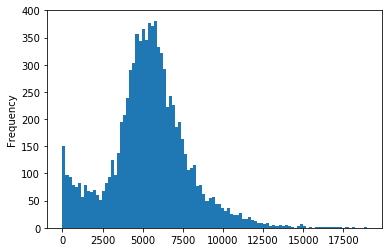

In [8]:
data["clean_text"].apply(lambda x: len(x.split())).plot(kind="hist",bins=100);

In [10]:
a = data["clean_text"].apply(lambda x: len(x.split()))
filtro = a[(a>2500)&(a<10000)].index
data = data.iloc[filtro]

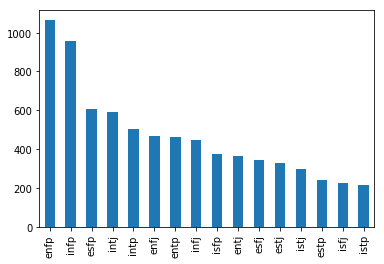

In [10]:
data["mbti"].value_counts().plot(kind="bar");

In [11]:
print(data.shape)
data.head()

(7505, 2)


,mbti,clean_text
0,entj,mencion que mirada tan interesante la de plut...
1,infp,algún día... podré ser bonita enlace tiempo d...
3,istj,cinco años sin participar de un día como este....
4,entp,acabo de terminar de ver gilmore girls por mil...
5,isfp,enlace hashtag enlace enlace llego mi mes enl...


# Code data

### Count Vectorizer Matrix

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=5000, ngram_range=(1,3))
X_matrix = vect.fit_transform(data["clean_text"])
X = pd.DataFrame(X_matrix.toarray(), columns = vect.get_feature_names())

In [ ]:
X.head()

### TFIDF matrix

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, ngram_range=(1,3))
X_matrix = vect.fit_transform(data["clean_text"])
X_tfidf = pd.DataFrame(X_matrix.toarray(), columns = vect.get_feature_names())

In [14]:
X_tfidf.head()

,abajo,abierto,about,abrazo,abrazo mencion,abrazos,abre,abril,abrir,absolutamente,...,última,últimamente,últimas,últimas horas,últimas horas enlace,último,últimos,única,único,único que
0,0.000000,0.0,0.000000,0.002253,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.001834,0.000000
1,0.011869,0.0,0.000000,0.018457,0.007648,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.013664,0.007512,0.009649
2,0.000000,0.0,0.003285,0.002674,0.000000,0.008227,0.000000,0.0,0.0,0.020328,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.002639,0.000000,0.000000
3,0.000000,0.0,0.008253,0.000000,0.000000,0.000000,0.004852,0.0,0.0,0.000000,...,0.003506,0.00937,0.0,0.0,0.0,0.0,0.00452,0.000000,0.016403,0.017556
4,0.000000,0.0,0.000000,0.012316,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.006684,0.008584


### LIWC vectors

In [ ]:
import sys
sys.path.append('../Utilities/')
from LIWC.LIWC_ES import LIWC_SPANISH
X_LIWC = LIWC_SPANISH(data["clean_text"])

### KFOLD f(x)

In [17]:
dict_code = {'i':0, 'e':1, 'n':0, 's':1, 'f':0, 't':1, 'j':0, 'p':1}
def code(tipo):
    """{'i':0, 'e':1, 'n':0, 's':1, 'f':0, 't':1, 'j':0, 'p':1} """
    return [dict_code[l] for l in tipo]

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
def LGBM_KFOLD(splits,X,Y):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

    f = 0
    scores = {}
    for i in range(4):
        scores[f"Y_{i}"] = []
    
    for train, test in kfold.split(X,Y):
        f+=1
    
        X_train,X_test = X.iloc[train].values,X.iloc[test].values
        Y_train,Y_test = Y.iloc[train],Y.iloc[test]
        
        for i in tqdm(range(4)):
            Y_n_train = [code(x)[i] for x in Y_train]
            Y_n_test = [code(x)[i] for x in Y_test]
            
            model = LGBMClassifier(class_weight="balanced")
            model.fit(X_train,Y_n_train)
            Y_pred = model.predict_proba(X_test)[:,1]
            score = roc_auc_score(Y_n_test,Y_pred)
            
            scores[f"Y_{i}"].append(score)

        print(f"KFOLD {f} Done")
    
    return pd.DataFrame(scores)  

# CountVectorizer Ngrams (1,3)

In [117]:
resultados = LGBM_KFOLD(5, X,data["mbti"])
print(resultados.describe())
resultados


KFOLD 1 Done



KFOLD 2 Done



KFOLD 3 Done



KFOLD 4 Done



KFOLD 5 Done
            Y_0       Y_1       Y_2       Y_3
count  5.000000  5.000000  5.000000  5.000000
mean   0.647423  0.601979  0.613047  0.584833
std    0.013504  0.007290  0.015873  0.015575
min    0.632558  0.589814  0.594997  0.560707
25%    0.634858  0.602095  0.607935  0.581358
50%    0.650222  0.602719  0.609881  0.587071
75%    0.655295  0.607470  0.613977  0.592535
max    0.664180  0.607799  0.638445  0.602494


,Y_0,Y_1,Y_2,Y_3
0,0.634858,0.589814,0.609881,0.560707
1,0.650222,0.607799,0.613977,0.581358
2,0.664180,0.607470,0.594997,0.602494
3,0.655295,0.602095,0.638445,0.592535
4,0.632558,0.602719,0.607935,0.587071


# TF-IDF Ngrams(1,3)

In [18]:
resultados = LGBM_KFOLD(5, X_tfidf,data["mbti"])
print(resultados.describe())
resultados


KFOLD 1 Done



KFOLD 2 Done



KFOLD 3 Done



KFOLD 4 Done



KFOLD 5 Done
            Y_0       Y_1       Y_2       Y_3
count  5.000000  5.000000  5.000000  5.000000
mean   0.651896  0.593516  0.617540  0.583497
std    0.011900  0.010115  0.012736  0.010414
min    0.635186  0.585295  0.600824  0.567202
25%    0.649559  0.586098  0.610088  0.580565
50%    0.649812  0.589606  0.616951  0.585065
75%    0.657256  0.596955  0.628033  0.591516
max    0.667666  0.609627  0.631802  0.593136


,Y_0,Y_1,Y_2,Y_3
0,0.649812,0.585295,0.600824,0.567202
1,0.649559,0.609627,0.628033,0.591516
2,0.667666,0.589606,0.610088,0.593136
3,0.657256,0.596955,0.631802,0.580565
4,0.635186,0.586098,0.616951,0.585065


# LIWC

In [124]:
resultados = LGBM_KFOLD(5, X_LIWC,data["mbti"])
print(resultados.describe())
resultados


KFOLD 1 Done



KFOLD 2 Done



KFOLD 3 Done



KFOLD 4 Done



KFOLD 5 Done
            Y_0       Y_1       Y_2       Y_3
count  5.000000  5.000000  5.000000  5.000000
mean   0.622816  0.579548  0.601328  0.562347
std    0.013464  0.014143  0.018303  0.016280
min    0.600407  0.558383  0.578701  0.538695
25%    0.621290  0.575027  0.592245  0.558188
50%    0.627053  0.582545  0.600513  0.559710
75%    0.630588  0.585177  0.607202  0.575032
max    0.634744  0.596609  0.627981  0.580112


,Y_0,Y_1,Y_2,Y_3
0,0.627053,0.558383,0.607202,0.558188
1,0.621290,0.582545,0.600513,0.580112
2,0.634744,0.596609,0.592245,0.575032
3,0.630588,0.575027,0.627981,0.559710
4,0.600407,0.585177,0.578701,0.538695


# Filter with PCA (CV + TFIDF + LIWC)

In [144]:
X_final = pd.concat([X,X_LIWC, X_tfidf], axis=1)
X_final.head()

,abajo,abierto,about,abrazo,abrazo mencion,abrazos,abre,abril,abrir,absolutamente,...,última,últimamente,últimas,últimas horas,últimas horas enlace,último,últimos,única,único,único que
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3,2,2
2,0,0,1,1,0,2,0,0,0,5,...,0,0,0,0,0,0,0,1,0,0
3,0,0,2,0,0,0,1,0,0,0,...,1,2,0,0,0,0,1,0,6,5
4,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2


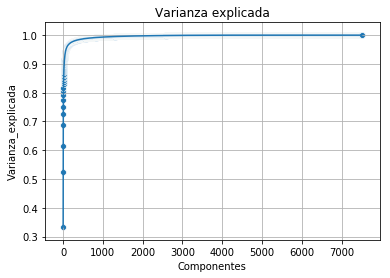

In [145]:
# ELEGIR NUMERO DE COMPONENTES 
from sklearn.decomposition import PCA
pca = PCA(n_components = None)                  #None para ver cuantos son utiles 
pca.fit(X_final)
varianza_explicada = pd.DataFrame(pca.explained_variance_ratio_).cumsum()

#Graficar varianza explicada con los componentes
import seaborn as sns 
import matplotlib.pyplot as plt
a = varianza_explicada.reset_index()
sns.lineplot(x=a["index"], y =a[0])
sns.scatterplot(x=a["index"], y =a[0])
plt.title('Varianza explicada')
plt.xlabel('Componentes')
plt.ylabel('Varianza_explicada')
plt.grid()
plt.show()

In [158]:
varianza_explicada[0].iloc[[100,200,300,600,500,600,700,800,900,1000]]

100     0.960382
200     0.974699
300     0.980927
600     0.988980
500     0.987114
600     0.988980
700     0.990433
800     0.991606
900     0.992578
1000    0.993399
Name: 0, dtype: float64

In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 500)                  #None para ver cuantos son utiles 
X_PCA = pd.DataFrame(pca.fit_transform(X_final))

In [160]:
resultados = LGBM_KFOLD(5, X_PCA,data["mbti"])
print(resultados.describe())
resultados


KFOLD 1 Done



KFOLD 2 Done



KFOLD 3 Done



KFOLD 4 Done



KFOLD 5 Done
            Y_0       Y_1       Y_2       Y_3
count  5.000000  5.000000  5.000000  5.000000
mean   0.621788  0.566345  0.596987  0.555331
std    0.022862  0.006561  0.017458  0.013237
min    0.592746  0.558527  0.577517  0.543835
25%    0.602934  0.563393  0.580355  0.545369
50%    0.628601  0.563653  0.599808  0.551409
75%    0.641446  0.571571  0.612694  0.559897
max    0.643211  0.574580  0.614559  0.576146


,Y_0,Y_1,Y_2,Y_3
0,0.641446,0.563393,0.599808,0.543835
1,0.602934,0.574580,0.614559,0.576146
2,0.628601,0.571571,0.577517,0.551409
3,0.643211,0.558527,0.612694,0.545369
4,0.592746,0.563653,0.580355,0.559897


# Train and Save models

In [13]:
pickle.dump(vect, open( "count_vectorizer_spanish.pkl", "wb" ) )   # Save countvectorizer vect

In [35]:
from lightgbm import LGBMClassifier
for i in range(4):
    model =  LGBMClassifier(class_weight="balanced")
    model.fit(X.values,[x[i] for x in data["mbti"]])
    pickle.dump(model, open(f"LGBM_SPANISH_{i}.pkl","wb"))  
    print(f"Done {i}")

Done 0
Done 1
Done 2
Done 3


In [1]:
import pickle 
def models():
    models = {}
    models["english"] = {}
    models["spanish"] = {}
    models["spanish"]["vect"] = pickle.load( open( "count_vectorizer_spanish.pkl", "rb" ) )
    
    for i in range(4):
        models["spanish"][f"LGBM{i}"] = pickle.load(open(f"LGBM_SPANISH_{i}.pkl","rb") )
        
    return models 

modelos = models()

In [2]:
def get_personality(text,language):
    """['e' 'i']
    ['n' 's']
    ['f' 't']
    ['j' 'p']"""
    if language=="spanish":
        personality = []
        text_coded = modelos[language]["vect"].transform([text]).toarray()

        for i in range(4):
            model = modelos["spanish"][f"LGBM{i}"]
            y_pred = model.predict_proba(text_coded)
            personality.append(y_pred)
    return personality

In [3]:
get_personality("I have a lot of friends","spanish")

[array([[0.5864998, 0.4135002]]),
 array([[0.46714103, 0.53285897]]),
 array([[0.6194938, 0.3805062]]),
 array([[0.6409809, 0.3590191]])]